https://github.com/damianboh/portfolio_optimization/blob/main/Max%20Sharpe%20Ratio%20Portfolio%20Optimization%20for%20Stocks%20Using%20PyPortfolioOpt.ipynb

In [1]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


Get Stock Prices using pandas_datareader Library
Let's get some data for the stock tickers that we want to include in our portfolio. The pandas-datareader library provides a method to pull stock price data from the web and store it in a DataFrame. 

If you do not pass in the start and end dates, stock prices will be given for the full date range available. Note that the date range may be different for different stocks depending on when they were listed.

In [3]:
start_date = '2013-01-01' 
end_date = '2022-4-17' 
tickers = ['MA','META','V','AMZN','JPM','BA'] 
stocks_df = yf.download(tickers,start=start_date,end=end_date)['Adj Close'] 
stocks_df.head()

[*********************100%***********************]  6 of 6 completed


Ticker,AMZN,BA,JPM,MA,META,V
Date,,,,,,
2013-01-02 00:00:00+00:00,12.8655,64.583862,32.511261,47.595810,27.942581,35.736618
2013-01-03 00:00:00+00:00,12.9240,64.919044,32.445744,47.663898,27.713053,35.764229
2013-01-04 00:00:00+00:00,12.9575,65.103394,33.020851,47.662045,28.701021,36.056328
2013-01-07 00:00:00+00:00,13.4230,63.796150,33.057251,48.488010,29.359669,36.313908
2013-01-08 00:00:00+00:00,13.3190,62.120155,33.122749,48.328415,29.000406,36.651993


In [4]:
fig_price = px.line(stocks_df,title='Price of Individual Stocks') 
fig_price.show() 

As seen above, Amazon seems to dominate the scale of the graph as the absolute price of the stock is very high. The graphs of all other stocks are flattened out. A graph like this is not very useful to compare the relative performance of the stocks. To address this, let's see how we can better measure the performance of a stock by exploring the concepts of daily returns and volatility.

Daily Returns
The daily returns of a stock is the fractional gain (or loss) on a given day relative to the previous day, it is given by (current day's close price - previous day's close price) / (previous day's close price). As it is a relative value, it provides a fairer comparison between stock returns regardless of absolute stock prices. The pct_change() method can be used to get the daily returns efficiently.

In [5]:
daily_returns = stocks_df.pct_change().dropna() 
daily_returns.head()

Ticker,AMZN,BA,JPM,MA,META,V
Date,,,,,,
2013-01-03 00:00:00+00:00,0.004547,0.005190,-0.002015,0.001431,-0.008214,0.000773
2013-01-04 00:00:00+00:00,0.002592,0.002840,0.017725,-0.000039,0.035650,0.008167
2013-01-07 00:00:00+00:00,0.035925,-0.020079,0.001102,0.017330,0.022949,0.007144
2013-01-08 00:00:00+00:00,-0.007748,-0.026271,0.001981,-0.003291,-0.012237,0.009310
2013-01-09 00:00:00+00:00,-0.000113,0.035478,-0.000659,0.028137,0.052650,0.015249


In [6]:
fig = px.line(daily_returns[['BA','V']],title='Daily Returns') 
fig.show() 

Volatility
Daily Volatility
Daily Volatility is the average difference between the return on a given day and the average return over the time period. Mathematically, it is just the standard deviation of the daily returns. Volatility is one of the measures of risk in that highly volatile investments can carry greater risk.

In [7]:
daily_returns.std()

Ticker
AMZN    0.019330
BA      0.023948
JPM     0.016772
MA      0.017019
META    0.022239
V       0.015621
dtype: float64

(-0.1, 0.1)

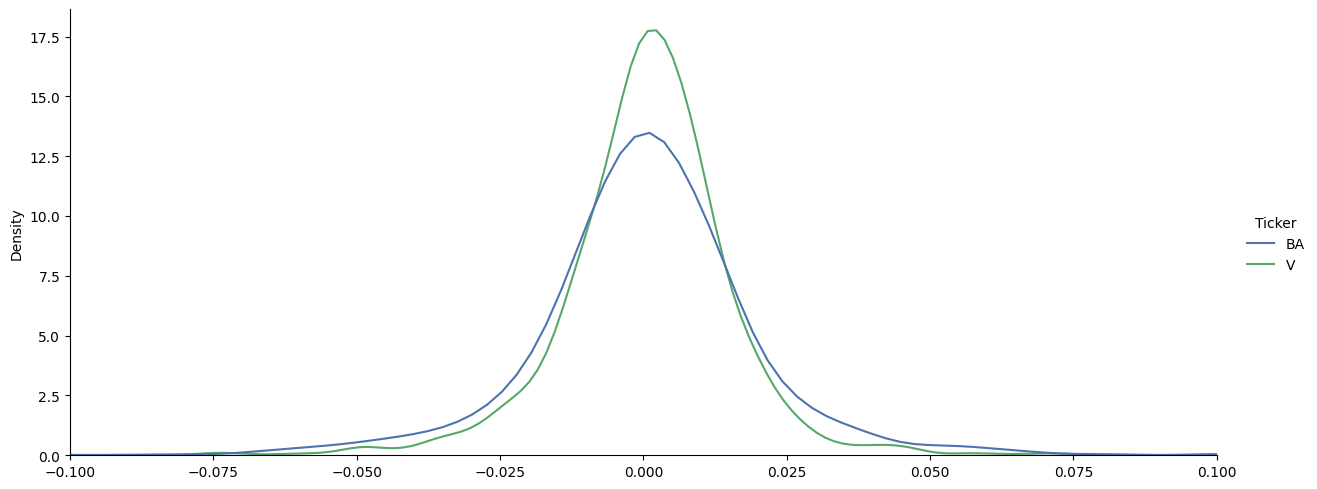

In [8]:
sns.displot(data=daily_returns[['BA','V']],kind='kde',aspect=2.5) 
plt.xlim(-0.1,0.1) 

Plot Individual Cumulative Returns
The cumulative returns of the stock can be easily calculated by adding one to the daily returns and taking the cumulative product over the whole period. Here we plot the cumulative returns of stocks starting with an initial investment of 100 (how much would investing 100 at the start in each individual stock get you over the time period?) This is a fair comparison for the performance of the stocks.

In [10]:
def plot_cum_returns(data,title):
    daily_cum_returns = (1 + daily_returns).cumprod() * 100 
    fig = px.line(daily_cum_returns,title=title) 
    return fig 
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
fig_cum_returns.show()

In [11]:
corr_df = stocks_df.corr().round(2) 
fig_corr = px.imshow(corr_df,text_auto=True,title='Correlation between Stocks') 
fig_corr.show() 

In [12]:
mu = expected_returns.mean_historical_return(stocks_df) 
S = risk_models.sample_cov(stocks_df) 
print(mu)

Ticker
AMZN    0.304666
BA      0.118103
JPM     0.149305
MA      0.241052
META    0.242676
V       0.209486
dtype: float64


In [13]:
def plot_efficient_frontier_and_max_sharpe(mu,S):
    ef = EfficientFrontier(mu,S) 
    fig,ax = plt.subplots(figsize=(8,6)) 
    ef_max_sharpe = copy.deepcopy(ef) 
    plotting.plot_efficient_frontier(ef,ax=ax,show_assets=False) 

    ef_max_sharpe.max_sharpe(risk_free_rate=0.02) 
    ret_tangent,std_tangent,_ = ef_max_sharpe.portfolio_performance() 
    ax.scatter(std_tangent,ret_tangent,marker="*",s=100,c="r",label="Max Sharpe") 

    n_samples = 100 
    w = np.random.dirichlet(np.ones(ef.n_assets),n_samples) 
    rets = w.dot(ef.expected_returns)  
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T)) 
    sharpes = rets / stds 
    ax.scatter(stds,rets,marker=".",c=sharpes,cmap="viridis_r") 

    ax.set_title("Efficient Frontier with Random Portfolios") 
    ax.legend() 
    plt.tight_layout() 
    plt.show() 

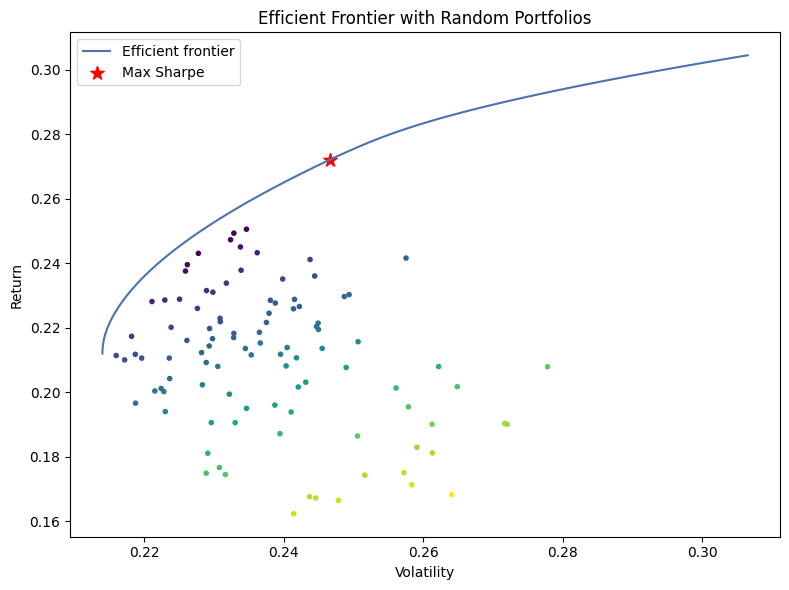

In [14]:
plot_efficient_frontier_and_max_sharpe(mu,S)

In [15]:
ef = EfficientFrontier(mu,S) 
ef.max_sharpe(risk_free_rate=0.02) 
weights = ef.clean_weights() 
print(weights) 


OrderedDict([('AMZN', 0.52723), ('BA', 0.0), ('JPM', 0.0), ('MA', 0.35911), ('META', 0.03502), ('V', 0.07864)])


In [16]:
weights_df = pd.DataFrame.from_dict(weights,orient='index') 
weights_df.columns = ['weights'] 
weights_df

,weights
AMZN,0.52723
BA,0.00000
JPM,0.00000
MA,0.35911
META,0.03502
V,0.07864


In [17]:
expected_annual_return,annual_volatility,sharpe_ratio = ef.portfolio_performance() 
print('Expected annual return:{}%'.format((expected_annual_return*100).round(2))) 
print("Annual Volatility:{}%".format((annual_volatility*100).round(2))) 
print('Sharpe ratio:{}'.format(sharpe_ratio.round(2)))

Expected annual return:27.22%
Annual Volatility:24.67%
Sharpe ratio:1.02


In [19]:
stocks_df['Optimized Portfolio'] = 0 
for ticker,weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight 
stocks_df.head()

Ticker,AMZN,BA,JPM,MA,META,V,Optimized Portfolio
Date,,,,,,,
2013-01-02 00:00:00+00:00,12.8655,64.583862,32.511261,47.595810,27.942581,35.736618,27.664086
2013-01-03 00:00:00+00:00,12.9240,64.919044,32.445744,47.663898,27.713053,35.764229,27.713513
2013-01-04 00:00:00+00:00,12.9575,65.103394,33.020851,47.662045,28.701021,36.056328,27.788079
2013-01-07 00:00:00+00:00,13.4230,63.796150,33.057251,48.488010,29.359669,36.313908,28.373439
2013-01-08 00:00:00+00:00,13.3190,62.120155,33.122749,48.328415,29.000406,36.651993,28.275301


In [20]:
fig_cum_returns_optimized = plot_cum_returns(stocks_df['Optimized Portfolio'], 'Cumulative Returns of Optimized Portfolio Starting with $100')
fig_cum_returns_optimized.show()